# Plotting geo run club maps

Amy Gilligan, Decemeber 2024 || amy.gilligan@abdn.ac.uk

## 0. Import the necessary packages 

I run this in my geopandas environment

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import gpxpy
import datetime
import pytz
import glob
import os
import math

import contextily as cx
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
from geodatasets import get_path
import matplotlib.patches as mpatches


## 1. Define some functions 

In [4]:
# function to load gpx files - from Dominic Williams

def gpxtodf(fname):
    gpx_file = open(fname, 'r')
    gpx = gpxpy.parse(gpx_file)
    track = gpx.tracks[0].segments[0].points
    
    data = []
    for point_idx, point in enumerate(track):
        data.append([point.longitude, point.latitude, point.elevation])

    df = pd.DataFrame(data, columns=['lon', 'lat', 'alt'])
    return(df)


#define the function distancetwopoints (haversine formula)
def distancetwopoints(lat1, lon1, lat2, lon2): #set the name of the function and the inputs
    """Finds the great circle distance between two locations in kilometers"""
    # find difference between latitudes and longitudes in radians
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
  
    # convert latitudes into to radians 
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
  
    # apply the haversine formulae 
    a = ((math.sin(dLat / 2)**2) + (math.sin(dLon / 2)**2) *  math.cos(lat1) * math.cos(lat2)); 
    radius = 6371 #radius of the Earth
    distance = radius * 2 * math.asin(math.sqrt(a)) 
    return distance #set what is returned - the distance between two points

## 2. Load the BGS geology and reformat

The shape file for the bedrock geology and the csv file for the BGS colours can be downloaded from digimap. Go to geology > geology digimap > zoom into the area you are interested in > click on download data > select download visible area > click on onshore geology, and select 1:50000 geology > click add to basket > click view basket > in format select SHAPE > click request download. You will then receive an email with the files to download. You will need to unzip the file you are sent. 

Don't run these cells if you're not interested in plotting the geology and go straight to section 5. 

In [5]:
# Read in the bedrock shape file
shape=gpd.read_file('/Users/s05ag8/metadata/geology/Download_2639249/bgs-50k_5762762/sc077/sc077_aberdeen_bedrock.shp')

# Read in the BGS colours csv file
colours=pd.read_csv('/Users/s05ag8/metadata/geology/Download_2639249/bgs-50k_5762762/docs/BGS_colours.csv')


In [6]:
# reformat the shape file to latitude and longitude, and cut it to the area you're interested in. 

shape_wgs84 = shape.to_crs({'init': 'epsg:4326'}) 
shape_wgs84=shape_wgs84.cx[-2.109:-2.075, 57.1574:57.1790]

/Users/s05ag8/anaconda3/envs/geopandas/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/s05ag8/anaconda3/envs/geopandas/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


## 3. Download a tif for the background map of the area you're interested in 

Contextily could be used to download it as a background instead using the add_basemap function. The problem with this with the geology is that the polygons in the shapefile extend over a larger area and so downloading it at a sensible resolution (e.g 15) takes ages.... If you don't want the geology use the version in section 5. 

In [7]:
# define area 

west, south, east, north = (
    -2.109,
    57.1574,
    -2.075,
    57.180
    
             )

# download the tif file - set the name/path and source appropriately

_ = cx.bounds2raster(west,
                                     south,
                                     east,
                                     north,
                                     ll=True,
                                     path="aberdeen.tif",
                                     source=cx.providers.CartoDB.Voyager
                                    )

## 4. Plot the geology, basemap, and gpx files on a single map

The geo_run_club_gpx folder can be downloaded as a zipped directory from github. It will need to be unzipped before use. 

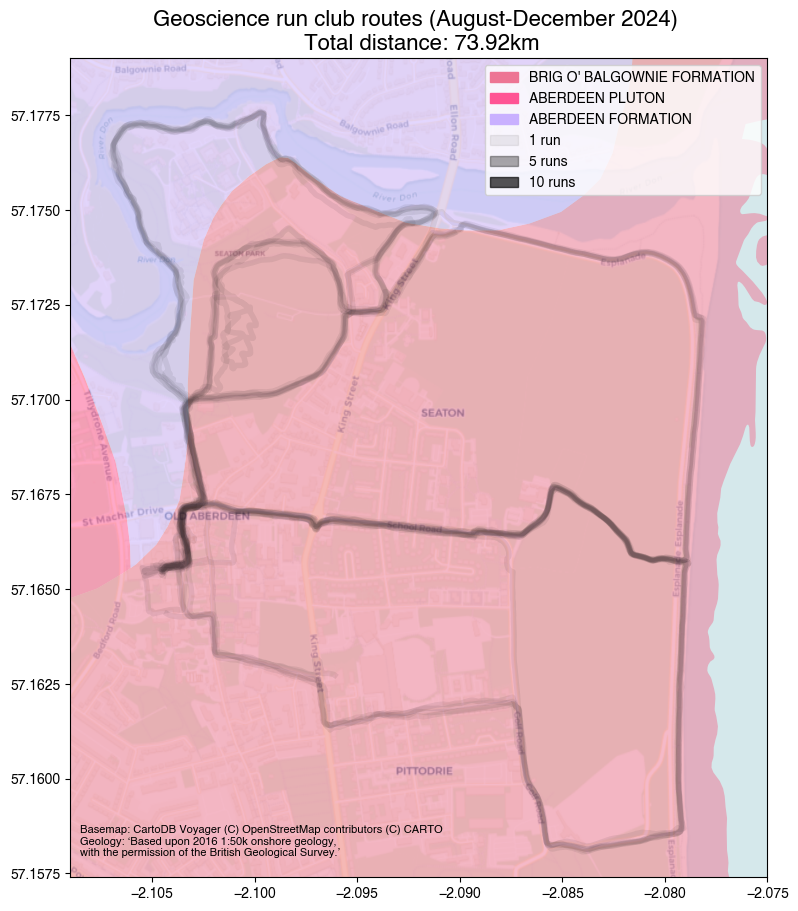

In [38]:
# set up the figure 
f, ax = plt.subplots(figsize=(9,11))
plt.rcParams['font.family'] = 'Helvetica'

# Loop through the geology polygons in the shape file and plot them with a transparency of 0.5 and the appropriate colour

count=0
handles=[]

for shapefile in [shape_wgs84]:
    count+=1

    for i in range(len(shapefile["LEX_RCS"].unique())):
        temp1=colours[colours['LEX_RCS']==shapefile["LEX_RCS"].unique()[i]].reset_index(drop=True)
        if len(temp1) >0:
            r=temp1['BGSRED'][0]
            g=temp1['BGSGREEN'][0]
            b=temp1['BGSBLUE'][0]
            shapefile[shapefile["LEX_RCS"] == shapefile["LEX_RCS"].unique()[i]].plot(ax=ax, color=(r/255, g/255, b/255), alpha=0.5)
        else:
            print(count, shapefile["LEX_RCS"].unique()[i]) 
        handles.append(mpatches.Patch(color=(r/255, g/255, b/255), label=shapefile["LEX_D"].unique()[i])) #add the units to the legend

# Loop through the gpx files, plotting them with a transparency determined by the number gpx files      
        
total_length=0
path="geo_run_club_gpx" # set the directory name to the variable path
gpxfiles=[x for x in os.listdir(path) if '.gpx' in x] #check each element (e.g file name) in the output of `os.listdir(path)`  to see if it contains the string `.gpx`, and if it does then write this to a new list called `gpxfiles`
for run in gpxfiles: #now loop through all files in the list gpx
    fname=path+'/'+run #set the path to the csv file relative to the current directory 
    run_df=gpxtodf(fname)
    ax.plot(run_df['lon'], run_df['lat'], linewidth=4, alpha=1/len(gpxfiles), color='k')
    
    # calculate the length of the run and add it total_length
    for i in range(len(run_df)):
        if i>0: 
            dist=distancetwopoints(run_df['lat'][i-1], run_df['lon'][i-1],run_df['lat'][i],run_df['lon'][i])
            total_length=total_length+dist

# add number of runs to legend            
            
handles.append(mpatches.Patch(color='k', alpha=1/len(gpxfiles), label='1 run'))
handles.append(mpatches.Patch(color='k', alpha=(5/len(gpxfiles)), label='5 runs'))
handles.append(mpatches.Patch(color='k', alpha=(10/len(gpxfiles)), label='10 runs'))
            
# cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
cx.add_basemap(ax, crs='epsg:4326', source="aberdeen.tif")
ax.set_xlim(-2.109, -2.075) # set longitude range
ax.set_ylim(57.1574, 57.1790) #set latitude range 
# set title
ax.set_title('Geoscience run club routes (August-December 2024) \n Total distance: '+str("%.2f" % total_length)+'km', fontname='Helvetica', fontsize=16)
# add legend
ax.legend(handles=handles)
# Add the basemap and geology attributions
t="Basemap: CartoDB Voyager (C) OpenStreetMap contributors (C) CARTO \nGeology: ‘Based upon 2016 1:50k onshore geology, \nwith the permission of the British Geological Survey.’"
ax.text(-2.1085, 57.158, t, wrap=True, fontsize=8)

# save the figure as a png
f.savefig('geo_runs_2024_with_geology', dpi=400, bbox_inches='tight')

## 5. Plot the basemap and gpx files on a single map

Use this version if you don't want to plot the geology. You don't need to run sections 2 and 3 in that case. The geo_run_club_gpx folder can be downloaded as a zipped directory from github. It will need to be unzipped before use. 

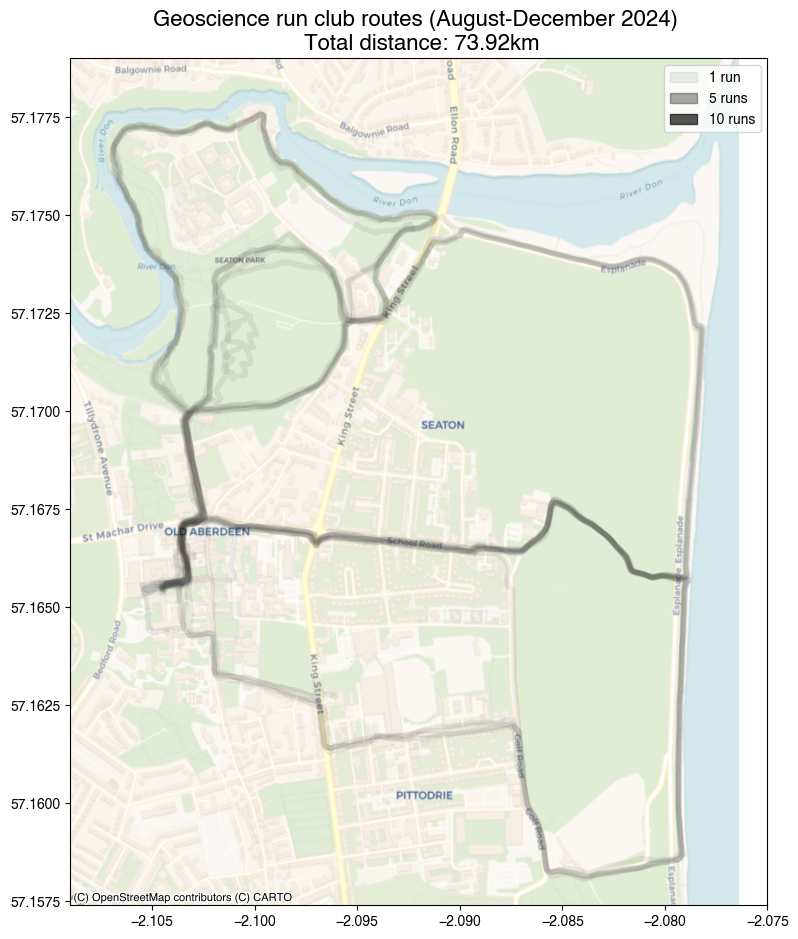

In [37]:
# set up the figure 
f, ax = plt.subplots(figsize=(9,11))
plt.rcParams['font.family'] = 'Helvetica'

handles=[]


# Loop through the gpx files, plotting them with a transparency determined by the number gpx files      
        
total_length=0
path="geo_run_club_gpx" # set the directory name to the variable path
gpxfiles=[x for x in os.listdir(path) if '.gpx' in x] #check each element (e.g file name) in the output of `os.listdir(path)`  to see if it contains the string `.gpx`, and if it does then write this to a new list called `gpxfiles`
for run in gpxfiles: #now loop through all files in the list gpx
    fname=path+'/'+run #set the path to the csv file relative to the current directory 
    run_df=gpxtodf(fname)
    ax.plot(run_df['lon'], run_df['lat'], linewidth=4, alpha=1/len(gpxfiles), color='k')
    
    # calculate the length of the run and add it total_length
    for i in range(len(run_df)):
        if i>0: 
            dist=distancetwopoints(run_df['lat'][i-1], run_df['lon'][i-1],run_df['lat'][i],run_df['lon'][i])
            total_length=total_length+dist

# add number of runs to legend            
            
handles.append(mpatches.Patch(color='k', alpha=1/len(gpxfiles), label='1 run'))
handles.append(mpatches.Patch(color='k', alpha=(5/len(gpxfiles)), label='5 runs'))
handles.append(mpatches.Patch(color='k', alpha=(10/len(gpxfiles)), label='10 runs'))
            
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlim(-2.109, -2.075) # set longitude range
ax.set_ylim(57.1574, 57.1790) #set latitude range 
# set title
ax.set_title('Geoscience run club routes (August-December 2024) \n Total distance: '+str("%.2f" % total_length)+'km', fontname='Helvetica', fontsize=16)
# add legend
ax.legend(handles=handles)

# save the figure as a png
f.savefig('geo_runs_2024.png', dpi=400, bbox_inches='tight')